In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE 

import nltk 
from nltk.corpus import stopwords 
import re 
from wordcloud import WordCloud

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kelvinfoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/Users/kelvinfoo/Desktop/AI Masters/AirBnb Project/Data/listing_with_embedding.csv')
df.head()

,Unnamed: 0,name,description,neighborhood_overview,host_is_superhost,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,amenities,price,review_scores_value,concat_info,embedding
0,0,"Easy going landlord,easy place",NaN,NaN,f,f,Bang Na,Private room,2,1,1,"[""Shampoo"", ""TV with standard cable"", ""First a...",2204,4.66,,[-1.18838310e-01 4.82986569e-02 -2.54812557e-...
1,1,Beautiful waterfront house,NaN,NaN,f,t,Don Mueang,Entire home/apt,1,1,4,"[""TV with standard cable"", ""Pets allowed"", ""Sm...",4440,4.66,,[-1.18838377e-01 4.82987203e-02 -2.54805246e-...
2,2,Sathorn Terrace Apartment(61),NaN,NaN,t,t,Bang Rak,Private room,2,1,1,"[""Shampoo"", ""Kitchen"", ""Hangers"", ""Elevator"", ...",1650,4.85,,[-1.18838295e-01 4.82987240e-02 -2.54809950e-...
3,3,Comfy bedroom near River pier & BTS Taksin.,This is one of our 'Escape' sleep room : hoste...,"Charoen krung street, River pier, Iconsiam, Su...",t,t,Sathon,Hotel room,2,1,1,"[""Shampoo"", ""Hangers"", ""Breakfast"", ""Hot water...",1536,4.69,This is one of our 'Escape' sleep room : hoste...,[ 6.04808740e-02 5.82088716e-02 1.96482660e-...
4,4,Central Bangkok 3 Bedroom Apartment,We are Airbnb Super Hosts. Book our apartment ...,Sukhumvit Rd is the shopping and restaurant di...,f,t,Khlong Toei,Entire home/apt,5,3,3,"[""Shampoo"", ""TV with standard cable"", ""Extra p...",5601,4.76,We are Airbnb Super Hosts. Book our apartment ...,[ 4.09337059e-02 -3.61530222e-02 5.19887842e-...


In [3]:
# Only apply clustering to listings where either description or neighbourhood overview is not empty
df_clustering = df[(df['description'].isnull() != 1) | (df['neighborhood_overview'].isnull() != 1)]

# Convert embeddings into 2D numpy array 
df_clustering['embedding'] = df_clustering['embedding'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]) if isinstance(x, str) else x)
X = np.vstack(df_clustering['embedding'].values)


/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/199013792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['embedding'] = df_clustering['embedding'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]) if isinstance(x, str) else x)


### **Clustering with K-Means**

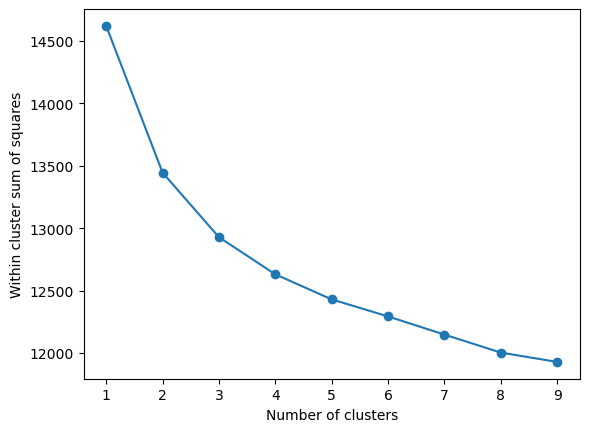

In [4]:
# Determine optimal number of clusters for embeddings + neighbourhood overview embeddings using elbow method 

wcss = [] # Within cluster sum of squares 
for i in range(1, 10): 
    kmeans = KMeans(n_clusters = i, random_state = 42, init = "k-means++", max_iter = 100, n_init = 1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares')
plt.show()


Based on elbow method, we set optimal number of clusters = 3.

/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/920982987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['cluster'] = kmeans.fit_predict(X)
/Users/kelvinfoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kelvinfoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/920982987.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

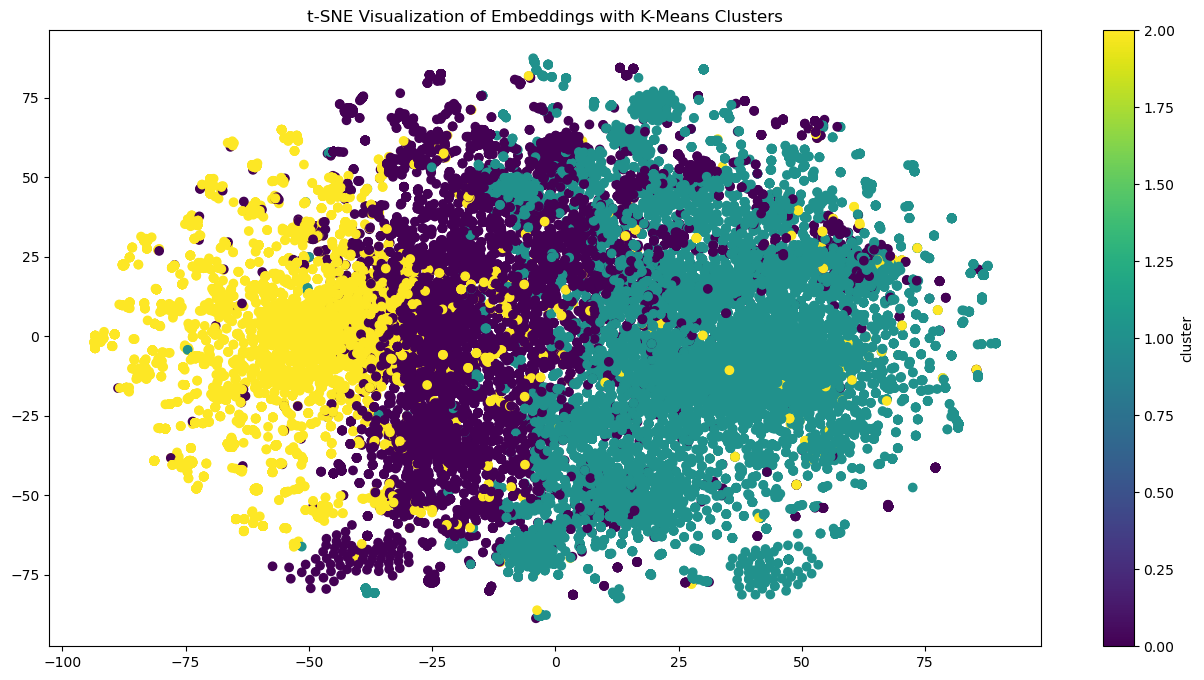

In [5]:
# Predict clustering for listings with k = 3 
kmeans = KMeans(n_clusters = 3, random_state = 42, init = "k-means++", max_iter = 100, n_init = 1)
df_clustering['cluster'] = kmeans.fit_predict(X)

# Apply T-SNE to determine if embeddings are well-seperated into clusters 
tsne = TSNE(n_components = 2, random_state = 42)
X_2d = tsne.fit_transform(X)

df_clustering['tsne_x'] = X_2d[:, 0]
df_clustering['tsne_y'] = X_2d[:, 1]

plt.figure(figsize = (16, 8))
scatter = plt.scatter(df_clustering['tsne_x'], df_clustering['tsne_y'], c = df_clustering['cluster'])
plt.colorbar(scatter, label = 'cluster')
plt.title("t-SNE Visualization of Embeddings with K-Means Clusters")
plt.show()

The embeddings are generally well-separated into 3 clusters. However, there is some overlap between the dark blue cluster and the green cluster.

In [6]:
print("Number of listings in each cluster: ")
print(df_clustering['cluster'].value_counts())

Number of listings in each cluster: 
1    11968
0     7831
2     5178
Name: cluster, dtype: int64


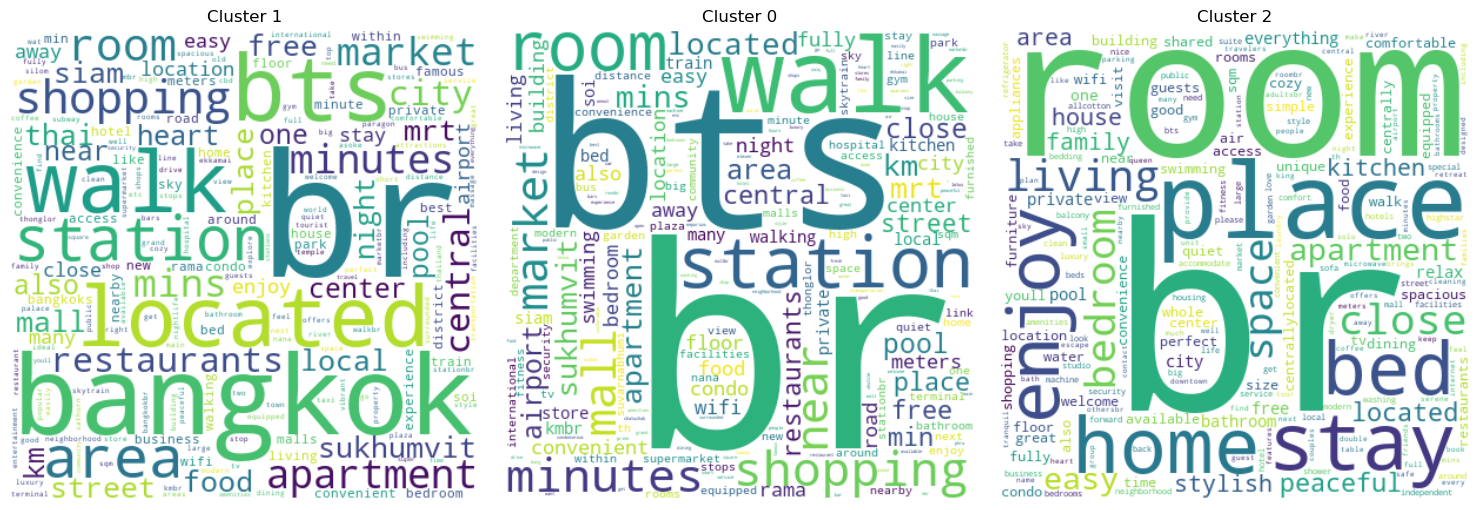

In [7]:
# Generate word cloud for each cluster 
def preprocess_text(text): 
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuations 
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words 

clusters = df_clustering['cluster'].unique()
fig, axes = plt.subplots(1, len(clusters), figsize=(15, 5))

word_count_per_cluster = {}
for i, cluster in enumerate(clusters): 
    cluster_texts = df_clustering[df_clustering['cluster'] == cluster]['concat_info']
    all_words = []
    for text in cluster_texts.dropna(): 
        all_words.extend(preprocess_text(text))
    
    word_counts = Counter(all_words)
    word_count_per_cluster[cluster] = word_counts.most_common(20)

    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {cluster}')

plt.tight_layout()
plt.show()



/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/789758730.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(words_list, rotation = 90)
/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/789758730.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(words_list, rotation = 90)
/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/789758730.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(words_list, rotation = 90)


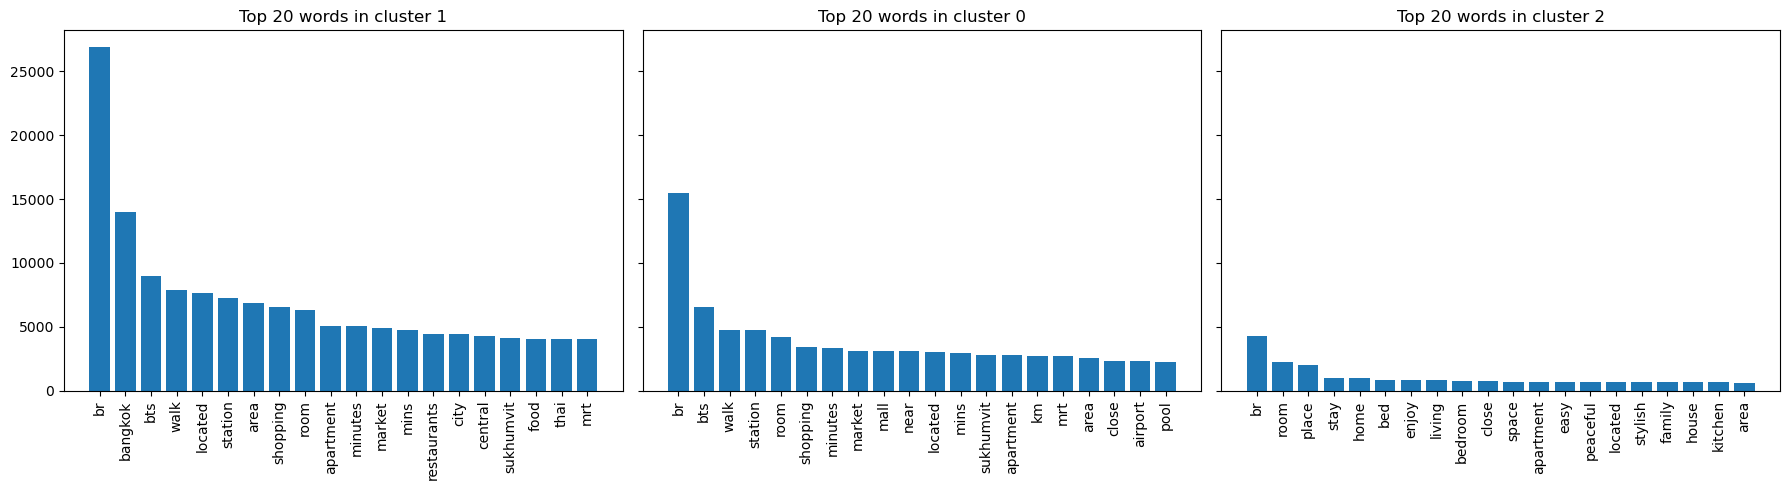

In [8]:
# Top 20 most common words in each cluster 
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (cluster, words) in enumerate(word_count_per_cluster.items()): 
    words_list, counts = zip(*words)

    axes[i].bar(words_list, counts)
    axes[i].set_xticklabels(words_list, rotation = 90)
    axes[i].set_title(f'Top 20 words in cluster {cluster}')

plt.tight_layout()
plt.show()

Cluster 0 and 1 seems to have an overlap as description and neighbourhood overview of listings in these cluster focus on convenience and proximity to amenities such as shopping malls, restaurant and BTS. Description and neighbourhood overview of listings in cluster 2 focus on the apartment itself, such as talking about the style of the apartment, living room and bedroom. 

### **Clustering with Agglomerative Clustering**

/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/2962857863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['agg_cluster'] = agg_clustering.fit_predict(X)
/Users/kelvinfoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kelvinfoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/2962857863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

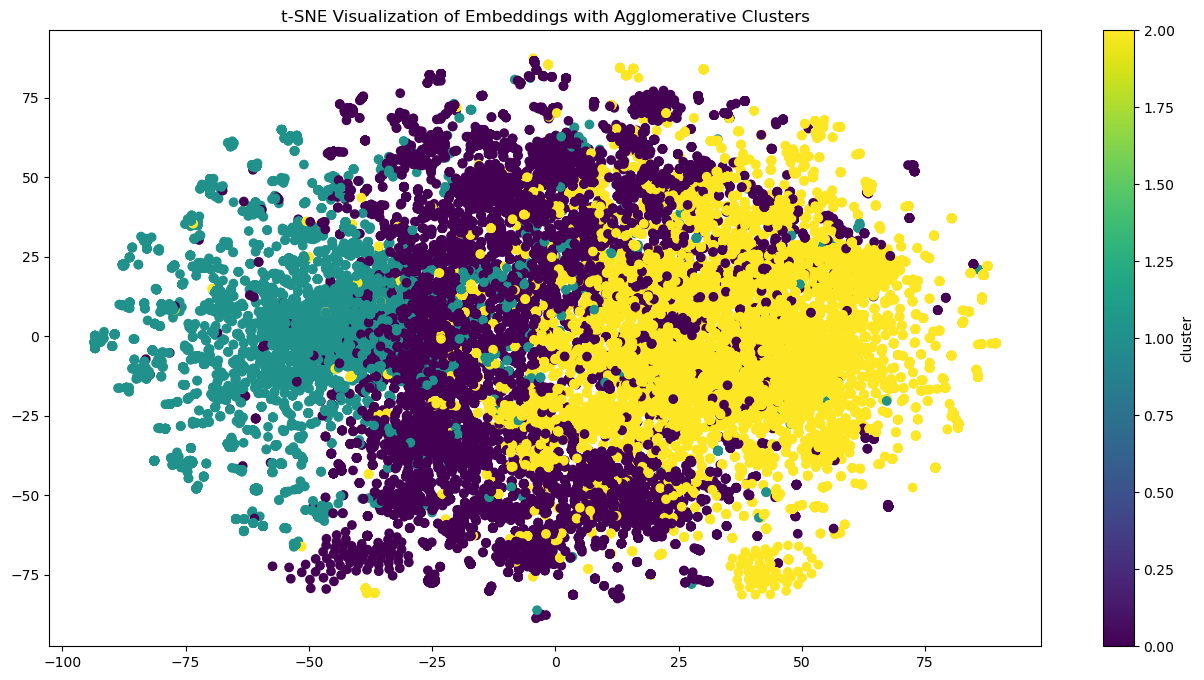

In [9]:
agg_clustering = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
df_clustering['agg_cluster'] = agg_clustering.fit_predict(X)

tsne = TSNE(n_components = 2, random_state = 42)
X_2d = tsne.fit_transform(X)

df_clustering['tsne_x'] = X_2d[:, 0]
df_clustering['tsne_y'] = X_2d[:, 1]

plt.figure(figsize = (16, 8))
scatter = plt.scatter(df_clustering['tsne_x'], df_clustering['tsne_y'], c = df_clustering['agg_cluster'])
plt.colorbar(scatter, label = 'cluster')
plt.title("t-SNE Visualization of Embeddings with Agglomerative Clusters")
plt.show()

The embeddings are generally well-separated into 3 clusters. However, there is some overlap between the dark blue cluster and the yellow cluster.

In [10]:
print("Number of listings in each cluster: ")
print(df_clustering['agg_cluster'].value_counts())

Number of listings in each cluster: 
0    10386
2     9496
1     5095
Name: agg_cluster, dtype: int64


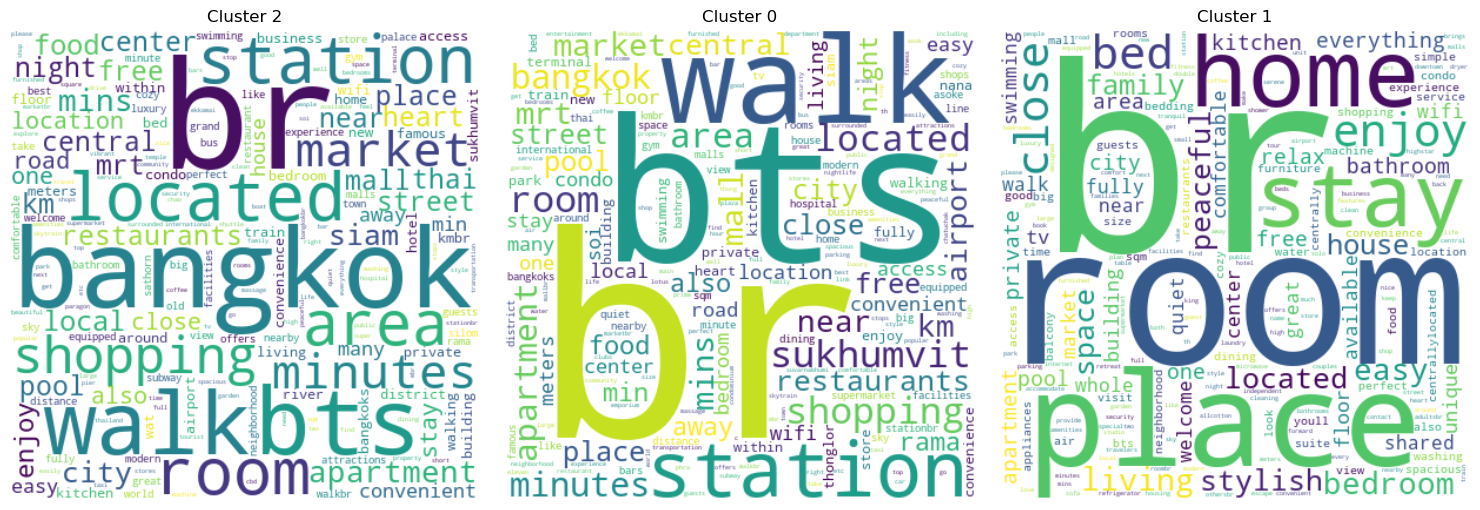

In [11]:
clusters = df_clustering['agg_cluster'].unique()
fig, axes = plt.subplots(1, len(clusters), figsize=(15, 5))

word_count_per_cluster = {}
for i, cluster in enumerate(clusters): 
    cluster_texts = df_clustering[df_clustering['agg_cluster'] == cluster]['concat_info']
    all_words = []
    for text in cluster_texts.dropna(): 
        all_words.extend(preprocess_text(text))
    
    word_counts = Counter(all_words)
    word_count_per_cluster[cluster] = word_counts.most_common(20)

    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {cluster}')

plt.tight_layout()
plt.show()

/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/789758730.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(words_list, rotation = 90)
/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/789758730.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(words_list, rotation = 90)
/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_1745/789758730.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(words_list, rotation = 90)


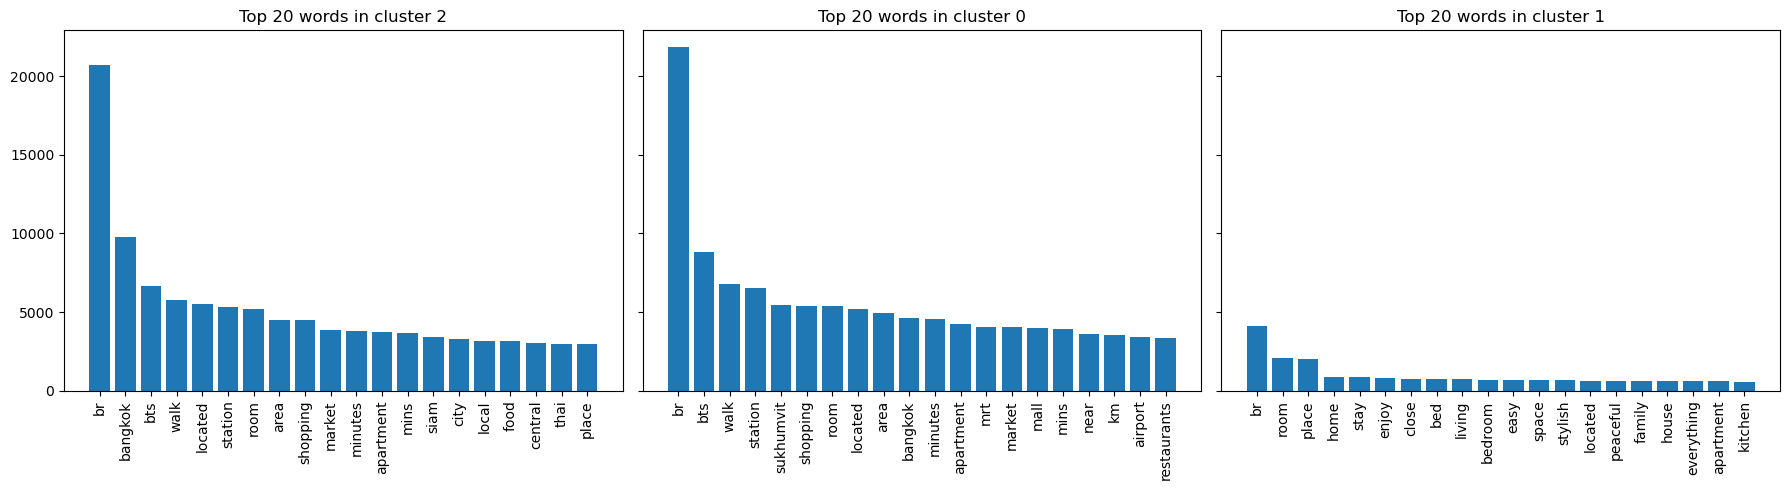

In [12]:
# Top 20 most common words in each cluster 
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (cluster, words) in enumerate(word_count_per_cluster.items()): 
    words_list, counts = zip(*words)

    axes[i].bar(words_list, counts)
    axes[i].set_xticklabels(words_list, rotation = 90)
    axes[i].set_title(f'Top 20 words in cluster {cluster}')

plt.tight_layout()
plt.show()

The results are relatively similar to that of K-Means clustering. 
Cluster 0 and 2 seems to have an overlap as description and neighbourhood overview of listings in these cluster focus on convenience and proximity to amenities such as shopping malls, restaurant and BTS. Description and neighbourhood overview of listings in cluster 1 focus on the apartment itself, such as talking about the style of the apartment, living room and bedroom. 

In [13]:
# Use agglomerative clustering as the eventual clustering algorithm 
df_clustering = df_clustering.drop(columns = ['concat_info', 'cluster', 'tsne_x', 'tsne_y'])
df_clustering.head()

,Unnamed: 0,name,description,neighborhood_overview,host_is_superhost,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,amenities,price,review_scores_value,embedding,agg_cluster
3,3,Comfy bedroom near River pier & BTS Taksin.,This is one of our 'Escape' sleep room : hoste...,"Charoen krung street, River pier, Iconsiam, Su...",t,t,Sathon,Hotel room,2,1,1,"[""Shampoo"", ""Hangers"", ""Breakfast"", ""Hot water...",1536,4.69,"[0.060480874, 0.0582088716, 0.0019648266, 0.05...",2
4,4,Central Bangkok 3 Bedroom Apartment,We are Airbnb Super Hosts. Book our apartment ...,Sukhumvit Rd is the shopping and restaurant di...,f,t,Khlong Toei,Entire home/apt,5,3,3,"[""Shampoo"", ""TV with standard cable"", ""Extra p...",5601,4.76,"[0.0409337059, -0.0361530222, 0.0519887842, 0....",0
10,10,Oasis in the heart of Bangkok,In the mid of vibrant in the center of Bangkok...,Local small food market during the day close t...,f,t,Ratchathewi,Entire home/apt,2,1,1,"[""Shampoo"", ""Freezer"", ""Kitchen"", ""Shared pool...",1366,4.86,"[0.0329679251, 0.0403496213, -0.0546748601, 0....",0
12,12,Monthly rent 2Beds/2Baths quiet APT at BTS,This is a monthly rented apartment. Our clean ...,Taksin is a very local residential neighborhoo...,t,t,Khlong San,Entire home/apt,4,2,2,"[""Shampoo"", ""Hangers"", ""Kitchen"", ""Free parkin...",1810,4.71,"[-0.0121601848, 0.019530328, -0.015967356, 0.0...",0
13,13,Nice room with superb city view,Our cool and comfortable one bedroom apartment...,It is very center of Bangkok and easy access t...,f,t,Ratchathewi,Entire home/apt,2,1,1,"[""Shampoo"", ""Kitchen"", ""Hangers"", ""Elevator"", ...",1878,4.75,"[0.111119725, -0.0271609426, 0.037512105, 0.00...",2


In [14]:
df_clustering.to_csv('/Users/kelvinfoo/Desktop/AI Masters/AirBnb Project/Data/listing_with_cluster.csv')